In [1]:
import re
import os
import pathlib
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results").resolve()

# Directory for tidied data (output directory)
data_dir = (pathlib.Path(project_dir) / "data").resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()



# Experiment constants
exp_name = "04_grpc_max_throughput"
file_prefix = "exp-04"

In [2]:
"""Load and prepare the dataset

resource_df -> CPU/Mem utilization for experiments
fortio_df -> Load test results from fortio
"""

# df = pd.read_feather(data_dir / "resource_results.feather")
df = pd.read_feather(data_dir / "fortio_results.feather")

df = df[df["experiment"] == exp_name]
df = df.drop("actual_qps", 1)
df = df.explode("latency")
df = df.reset_index(drop=True)
df = df.astype({
    "experiment": "category",
    "mesh": "category",
    "requested_qps": "category",
    "payload": "category",
    "protocol": "category",
    "latency": np.float64,
})

df = df.sort_values("mesh", ascending=True)

df.head()

,experiment,mesh,requested_qps,protocol,payload,latency
14713629,04_grpc_max_throughput,Baseline,MAX,grpc,0,3.302627
10962408,04_grpc_max_throughput,Baseline,MAX,grpc,0,2.360246
10962409,04_grpc_max_throughput,Baseline,MAX,grpc,0,2.067287
10962410,04_grpc_max_throughput,Baseline,MAX,grpc,0,2.371735
10962411,04_grpc_max_throughput,Baseline,MAX,grpc,0,2.370873


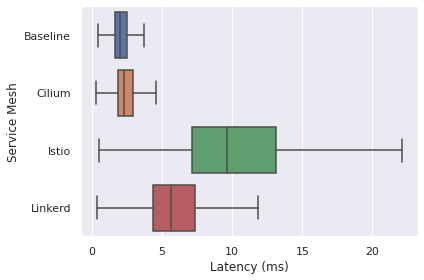

In [6]:
"""
PLOT: Boxplot latency by mesh
Desc: Show 25p med 50p latencies
"""

file_name = f"{file_prefix}-latency.pdf"

fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x="latency", y="mesh", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")

# ax.set_xscale("log")

fig.tight_layout()
fig.savefig(plot_dir / file_name)

In [7]:
# The quantiles to plot
quantiles = [
    0.99,
    0.999,
    0.9999
]

data = df.groupby("mesh")["latency"].quantile(quantiles)
data = data.reset_index().rename(columns={"level_1": "percentile"})
data["percentile"] *= 100
data.head()

,mesh,percentile,latency
0,Baseline,99.00,8.699719
1,Baseline,99.90,17.348388
2,Baseline,99.99,67.603146
3,Cilium,99.00,10.024353
4,Cilium,99.90,20.819516


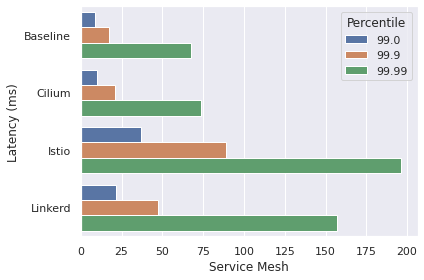

In [8]:

"""
PLOT: Tail End Latencies
"""

# Plotting
file_name = f"{file_prefix}-tail-latencies.pdf"

fig, ax = plt.subplots()
ax = sns.barplot(data=data, y="mesh", x="latency", order=["Baseline", "Cilium", "Istio", "Linkerd"], hue="percentile")

# Scaling
# ax.set_xscale()
# ax.set_yscale()

# Limits
# ax.set_xscale()
# ax.set_yscale()

# Labels
ax.set_xlabel("Service Mesh")
ax.set_ylabel("Latency (ms)")

# ax.legend(labels=["p99", "p99.9", "p99.99"], title= "Percentiles")
ax.legend(title= "Percentile")

fig.tight_layout()
fig.savefig(plot_dir / file_name)

In [20]:
data = df[df["mesh"] == "Istio"]
qt = data["latency"].quantile(.999)
data.loc[data["latency"] > qt]


,experiment,mesh,requested_qps,protocol,payload,latency
19030142,04_grpc_max_throughput,Istio,MAX,grpc,0,128.230283
19030141,04_grpc_max_throughput,Istio,MAX,grpc,0,134.836047
19030140,04_grpc_max_throughput,Istio,MAX,grpc,0,182.746972
19030139,04_grpc_max_throughput,Istio,MAX,grpc,0,177.884669
19030138,04_grpc_max_throughput,Istio,MAX,grpc,0,145.185617
...,...,...,...,...,...,...
19028635,04_grpc_max_throughput,Istio,MAX,grpc,0,89.290562
19028662,04_grpc_max_throughput,Istio,MAX,grpc,0,89.198869
19028648,04_grpc_max_throughput,Istio,MAX,grpc,0,89.891302
19028604,04_grpc_max_throughput,Istio,MAX,grpc,0,89.778503


In [14]:
df["latency"].quantile(.999)

41.16934817422722